In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

(576, 1024, 3)


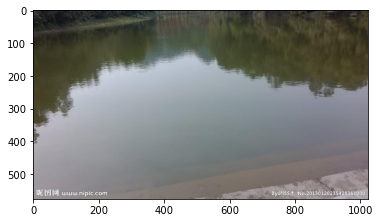

In [14]:
I = mpimg.imread('./water_image.jpeg')
print(I.shape)
plt.imshow(I)

In [16]:
width = 600 #宽度
height = 480 #高度
image = I
dropRadius = 3  # 波源半径大小
delay = 1
attenuation = 5
maxAmplitude = 1024
sourceAmplitude = 512 # 震源振幅

In [20]:
half_width = width >> 1
half_height = height >> 1
amplitude_size = width * (height + 2) * 2 #振幅数组大小
old_index = width
new_index = width * (height + 3)

# 波幅数组初始化为0
ripple_map = np.zeros((width, height+2))  #产生水波下一时刻振幅
last_map = np.zeros((width, height+2))  #初始时刻振幅

In [18]:
amplitude_size

578400

In [21]:
def calculAmplitude(ripple_map, x, y):
    x_boundary = 0
    judge = index % width
    
    # 由于波幅数据顺序存储，加上左右边界检查，避免左边水波传递到右边
    if judge == 0:
        x_boundary = 1 # 左边边界
    elif judge == width - 1:
        x_boundary = 2 # 右边边界
    
    top = ripple_map[x][y-1] # 上边的相邻点
    bottom = ripple_map[x][y+1] #下边的相邻点
    
    if x_boundary != 1:
        left = ripple_map[x-1][y] # 左边的相邻点
    else:
        left = 0
        
    if x_boundary != 2:
        right = ripple_map[x+1][y] # 右边的相邻点
    else:
        right = 0
    
    # 计算当前像素点下一时刻的振幅
    amplitude = top + bottom + left + right
    amplitude >>= 1
    amplitude -= ripple_map[x][y]
    amplitude -= amplitude >> 5  # 计算衰减
    return amplitude

In [12]:
def renderRipple(ripple_map, ripple_data, height, width):
    deviation_x = 0 # x水平方向偏移
    deviation_y = 0  # y竖直方向偏移
    pixel_deviation = 0 # 偏移后的ImageData对象像素索引
    pixel_source = 0  # 原始ImageData对象像素索引

    # 设置像素索引和振幅索引
    i = 0
    map_index = old_index
    new_ripple_map = np.zeros((width, height+2))

    # 渲染所有像素点
    for y in range(1, height-1):
        for x in range(width):
            # 计算当前像素点下一时刻的振幅
            amplitude = calculAmplitude(ripple_map, x, y)

            # 更新振幅数组
            new_ripple_map[x][y] = amplitude

            amplitude = 1024 - amplitude
            old_amplitude = ripple_map[x][y]

            if old_amplitude != amplitude:
                # 计算偏移
                deviation_x = (((x - half_width) * amplitude / 1024) << 0) + half_width
                deviation_y = (((y - half_height) * amplitude / 1024) << 0) + half_height

                # 检查边界
                if deviation_x > width:
                    deviation_x = width - 1
                
                if deviation_x < 0:
                    deviation_x = 0
                
                if deviation_y > height:
                    deviation_y = height - 1
                
                if deviation_y < 0:
                    deviation_y = 0

                # 移动像素的RGBA信息，ripple和texture为背景图的ImageData对象
                ripple_data[x][y] = texture_data[deviation_x][deviation_y]
        
    return ripple

In [ ]:
def disturb(circleX, circleY):
    # 下面的移位运算可以将值向下取整
    circleX <<= 0
    circleY <<= 0
    maxDistanceX = circleX + dropRadius
    maxDistanceY = circleY + dropRadius
    for y in range(circleY - dropRadius, maxDistanceY):
        for x in range(circleX - dropRadius, maxDistanceX):
            ripple_map[old_index + y * width + x] += 512